In [ ]:
# Step 1: Install opendatasets and download Chest X-Ray dataset
!pip install opendatasets --quiet

import opendatasets as od
od.download("https://www.kaggle.com/datasets/pranavgautam29/chest-x-ray-imagesmultiple-diseases")

Skipping, found downloaded files in "./chest-x-ray-imagesmultiple-diseases" (use force=True to force download)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
DATASET_DIR = "./chest-x-ray-imagesmultiple-diseases/data"


In [ ]:
# 2. List categories (folders)
categories = [cat for cat in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, cat))]
print("Categories:", categories)


Categories: ['Tuberculosis', 'Pneumothorax', 'Normal', 'Pneumonia', 'Covid']


In [ ]:
# 3. Count images in each category
class_counts = {}
for category in categories:
    category_path = os.path.join(DATASET_DIR, category)
    class_counts[category] = len([img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))])
print("Number of images per category:", class_counts)


Number of images per category: {'Tuberculosis': 700, 'Pneumothorax': 1012, 'Normal': 1118, 'Pneumonia': 1246, 'Covid': 377}


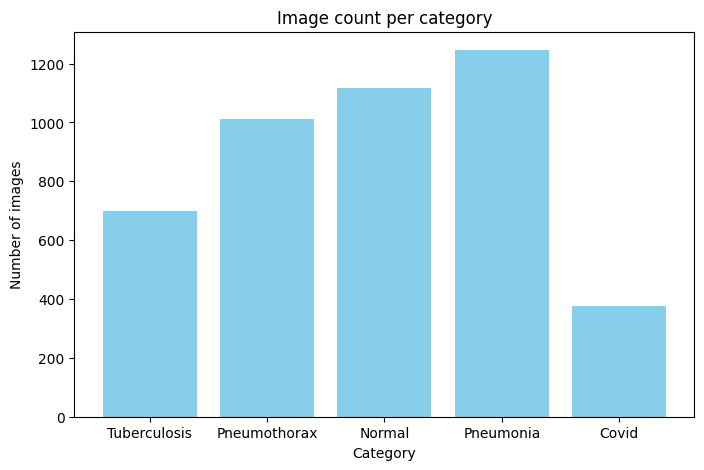

In [ ]:
# 4. Plot class distribution
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image count per category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.show()


In [ ]:
import os
import shutil
import random

# Source and target directories
source_dir = "chest-x-ray-imagesmultiple-diseases/data"
target_dir = "Source_data"
classes = ['Covid', 'Normal', 'Pneumonia', 'Pneumothorax', 'Tuberculosis']

# Ratios
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Create destination folders
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(target_dir, split, cls), exist_ok=True)

# Split and move images
for cls in classes:
    cls_source = os.path.join(source_dir, cls)
    images = os.listdir(cls_source)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_split * n_total)
    n_val   = int(val_split * n_total)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train + n_val]
    test_imgs  = images[n_train + n_val:]

    for img_name in train_imgs:
        shutil.copy(
            os.path.join(cls_source, img_name),
            os.path.join(target_dir, 'train', cls, img_name)
        )

    for img_name in val_imgs:
        shutil.copy(
            os.path.join(cls_source, img_name),
            os.path.join(target_dir, 'val', cls, img_name)
        )

    for img_name in test_imgs:
        shutil.copy(
            os.path.join(cls_source, img_name),
            os.path.join(target_dir, 'test', cls, img_name)
        )

print("✅ Dataset successfully split into Source_data/train, val, test")


✅ Dataset successfully split into Source_data/train, val, test


In [ ]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
FINE_TUNE_EPOCHS = 5
DATASET_DIR = "Source_data"

In [ ]:
# STEP 1: LOAD DATA
# ===============================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

Found 3114 files belonging to 5 classes.
Found 664 files belonging to 5 classes.
Found 674 files belonging to 5 classes.


In [ ]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# STEP 2: DATA AUGMENTATION
# ===============================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [ ]:
# STEP 3: BUILD DenseNet121 MODEL
# ===============================
base_densenet = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3)
)
base_densenet.trainable = False

shebam_model_densenet = models.Sequential([
    data_augmentation,
    layers.Lambda(tf.keras.applications.densenet.preprocess_input),
    base_densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

shebam_model_densenet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


In [ ]:

print("Training DenseNet-121...")
history_dense = shebam_model_densenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

Training DenseNet-121...
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 749s 7s/step - accuracy: 0.5384 - loss: 1.2498 - val_accuracy: 0.6973 - val_loss: 0.6253 - learning_rate: 0.0010
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 721s 7s/step - accuracy: 0.7180 - loss: 0.7058 - val_accuracy: 0.8087 - val_loss: 0.4728 - learning_rate: 0.0010
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 741s 7s/step - accuracy: 0.7410 - loss: 0.6454 - val_accuracy: 0.8208 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 4/10
 7/98 ━━━━━━━━━━━━━━━━━━━━ 8:29 6s/step - accuracy: 0.8371 - loss: 0.4470

In [ ]:
# STEP 6: FINE-TUNING BOTH MODELS
# ===============================
# Fine-tune DenseNet
base_densenet.trainable = True
for layer in base_densenet.layers[:int(len(base_densenet.layers) * 0.7)]:
    layer.trainable = False
shebam_model_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
shebam_model_densenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)


In [ ]:
# STEP 7: EVALUATE AND COMPARE
# ===============================
print("Evaluating DenseNet-121...")
dense_loss, dense_acc = shebam_model_densenet.evaluate(test_ds)

print(f"\nDenseNet-121 Test Accuracy: {dense_acc:.4f}")

# Classification Reports
y_true = np.concatenate([y for x, y in test_ds])
y_pred_dense = np.argmax(shebam_model_densenet.predict(test_ds), axis=1)

print("\nDenseNet-121 Classification Report:")
print(classification_report(y_true, y_pred_dense, target_names=class_names))


In [ ]:
shebam_model_densenet.save("shebam_model_densenet_finetuned.h5")
print("Model saved")